<center>
  <img src="https://www.inteli.edu.br/wp-content/uploads/2024/06/logo-inteli-3-768x420-1.png" width="20%" />
</center>

# `[SI11-2024]` - Prova Prática

Sistemas de Informação - Módulo 11 - Turma 4

**Nome**: *Pedro Rezende*

**ANTES DE PROSSEGUIR FAÇA UMA CÓPIA DESTE NOTEBOOK**

----

## Problema

A **DeságuaPK** é uma empresa de distribuição de água que atende uma grande quantidade de consumidores em diferentes regiões. Nos últimos anos, a empresa identificou um aumento significativo nas fraudes de consumo, onde alguns clientes manipulam suas medições de água para reduzir suas contas. Essas fraudes representam uma perda substancial de receita e, em alguns casos, comprometem a distribuição eficiente de água para outros clientes.

A empresa possui um histórico de três anos de consumo de água de diversos clientes, incluindo uma coluna que indica se o consumo foi fraudado ou não. Seu objetivo é auxiliar a DeságuaPK a identificar padrões nos dados e propor soluções eficientes para detectar fraudes de forma automática. Para isso, você deverá utilizar dois tipos de redes neurais: feedforward e LSTM.

Sua tarefa:

In [1]:
# https://drive.google.com/file/d/1iqMAnLCVFN_bZUW5EGo7CjsbYMJDbg6x/view?usp=sharing
!gdown 1iqMAnLCVFN_bZUW5EGo7CjsbYMJDbg6x

Downloading...
From: https://drive.google.com/uc?id=1iqMAnLCVFN_bZUW5EGo7CjsbYMJDbg6x
To: /content/desagua-pk.csv
100% 224k/224k [00:00<00:00, 136MB/s]


In [42]:
import pandas as pd
df = pd.read_csv('/content/desagua-pk.csv', sep=";")
df.head()

,matricula,data_leitura,consumo_m3,categoria,fraude
0,100000,2021-01-01,10.373154,RESIDENCIAL,0
1,100000,2021-02-01,9.573877,RESIDENCIAL,0
2,100000,2021-03-01,10.243896,RESIDENCIAL,0
3,100000,2021-04-01,9.788781,RESIDENCIAL,0
4,100000,2021-05-01,10.287611,RESIDENCIAL,0


In [5]:
%load_ext cudf.pandas

In [97]:
# importações
import pandas as pd
import numpy as np
import os
import re
from datetime import datetime
import gdown
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout, BatchNormalization
from tensorflow.keras.metrics import BinaryAccuracy, AUC, Precision, Recall, Accuracy, TruePositives, TrueNegatives, FalsePositives, FalseNegatives
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam, Lion
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
tf.random.set_seed(42)

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, make_scorer, accuracy_score

import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM
from tensorflow.keras.metrics import BinaryAccuracy, AUC, Precision, Recall, Accuracy, F1Score
from tensorflow.keras.optimizers import Adam, Lion, RMSprop
from tensorflow.keras.losses import BinaryCrossentropy

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, make_scorer, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

## 1. Exploração de Dados

Realize uma análise exploratória dos dados, buscando padrões que diferenciem consumidores normais de fraudadores. Você deve investigar possíveis correlações entre o consumo de água e a presença de fraudes, e observar características que possam ser úteis no treinamento dos modelos.

Visualize e descreva as diferenças entre os comportamentos de consumo de clientes fraudadores e não fraudadores, utilizando gráficos e métricas descritivas.

- Somente com essa linha de código, podemos ver algumas informações do dataset.
  - Possui 5 colunas, com um total de 4500 registros
  - Temos duas colunas de valores inteiros
  - Uma coluna de valores racionais
  - Duas colunas de calores descritivos
  - Não temos nenhum valor vazio também!

In [43]:
df.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   matricula     4500 non-null   int64
 1   data_leitura  4500 non-null   object
 2   consumo_m3    4500 non-null   float64
 3   categoria     4500 non-null   object
 4   fraude        4500 non-null   int64
dtypes: float64(1), int64(2), object(2)
memory usage: 230.3+ KB


In [44]:
df['data_leitura'] = pd.to_datetime(df['data_leitura'], errors='coerce')

In [45]:
df.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   matricula     4500 non-null   int64
 1   data_leitura  4500 non-null   datetime64[ns]
 2   consumo_m3    4500 non-null   float64
 3   categoria     4500 non-null   object
 4   fraude        4500 non-null   int64
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 203.9+ KB


- Aqui conseguimos analisar que temos 100 matriculas únicas no nosso dataset
- Além disso, é possível perceber que cada uma dessas matrículas aparecem 45 vezes
- Logo, 100 matriculas únicas, cada uma aparecendo 45 vezes, temos um total de 4500 matriculas (como mostrado na quantidade de registro dos datasets)

In [46]:
num_matriculas_unicas = df['matricula'].nunique()
print(f"Número de matrículas únicas: {num_matriculas_unicas}")

contagem_matriculas = df['matricula'].value_counts()
print("\nContagem de registros por matrícula (primeiros 10):")
print(contagem_matriculas.head(10))

Número de matrículas únicas: 100

Contagem de registros por matrícula (primeiros 10):
matricula
100000    45
100001    45
100002    45
100003    45
100004    45
100005    45
100006    45
100007    45
100008    45
100009    45
Name: count, dtype: int64


In [47]:
df['data_leitura'].value_counts()

data_leitura
2021-01-01    100
2021-02-01    100
2021-03-01    100
2021-04-01    100
2021-05-01    100
2021-06-01    100
2021-07-01    100
2021-08-01    100
2021-09-01    100
2021-10-01    100
2021-11-01    100
2021-12-01    100
2022-01-01    100
2022-02-01    100
2022-03-01    100
2022-04-01    100
2022-05-01    100
2022-06-01    100
2022-07-01    100
2022-08-01    100
2022-09-01    100
2022-10-01    100
2022-11-01    100
2022-12-01    100
2023-01-01    100
2023-02-01    100
2023-03-01    100
2023-04-01    100
2023-05-01    100
2023-06-01    100
2023-07-01    100
2023-08-01    100
2023-09-01    100
2023-10-01    100
2023-11-01    100
2023-12-01    100
2024-01-01    100
2024-02-01    100
2024-03-01    100
2024-04-01    100
2024-05-01    100
2024-06-01    100
2024-07-01    100
2024-08-01    100
2024-09-01    100
Name: count, dtype: int64

- Aqui é possível perceber que temos menos registros em 2024

In [48]:
df['ano'] = df['data_leitura'].dt.year
contagem_por_ano = df['ano'].value_counts()
contagem_por_ano

ano
2021    1200
2022    1200
2023    1200
2024     900
Name: count, dtype: int64

- Porém, a distribuição de valores para cada mes é igual

In [49]:
df['mes'] = df['data_leitura'].dt.month
contagem_por_mes_ano = df.groupby(['ano', 'mes'])['matricula'].count()
contagem_por_mes_ano

ano   mes
2021  1      100
      2      100
      3      100
      4      100
      5      100
      6      100
      7      100
      8      100
      9      100
      10     100
      11     100
      12     100
2022  1      100
      2      100
      3      100
      4      100
      5      100
      6      100
      7      100
      8      100
      9      100
      10     100
      11     100
      12     100
2023  1      100
      2      100
      3      100
      4      100
      5      100
      6      100
      7      100
      8      100
      9      100
      10     100
      11     100
      12     100
2024  1      100
      2      100
      3      100
      4      100
      5      100
      6      100
      7      100
      8      100
      9      100
Name: matricula, dtype: int64

- Aqui é possível perceber como o consumo por m³ foi decaindo com o passar do tempo

In [50]:
import plotly.express as px

fig = px.histogram(df, x="data_leitura", y="consumo_m3", nbins=50, title="Distribuição do Consumo de Água por Data")
fig.show()

- Em um gráfico simples como esse, percebemos como a descrepancia entre o consumo de fraude, em comparação com não fraudes, ao decorrer dos anos

In [51]:
fig = px.histogram(df, x="ano", y="consumo_m3", color="fraude", barmode='group', title="Distribuição do Consumo de Água por Ano")
fig.show()

- Temos uma descrepancia nos valores de fraudes, o que pode atrapalhar durante o treinamento do modelo, para isso, iremos aplicar duas técnicas para testar, UnderSample e o OverSample

In [52]:
df['fraude'].value_counts()

fraude
0    3442
1    1058
Name: count, dtype: int64

- Aqui é possível perceber a diferença de quantidade de fraudes por categoria, isso é outra coisa que pode chegar a afetar o modelo, então teremos que tratar.

In [53]:
df['categoria'].value_counts()

categoria
RESIDENCIAL    3150
COMERCIAL      1350
Name: count, dtype: int64

In [54]:
fig = px.histogram(df, x="fraude", y="categoria", title="Quantidade de Fraudadores por Categoria")
fig.show()

In [55]:
df

,matricula,data_leitura,consumo_m3,categoria,fraude,ano,mes
0,100000,2021-01-01,10.373154,RESIDENCIAL,0,2021,1
1,100000,2021-02-01,9.573877,RESIDENCIAL,0,2021,2
2,100000,2021-03-01,10.243896,RESIDENCIAL,0,2021,3
3,100000,2021-04-01,9.788781,RESIDENCIAL,0,2021,4
4,100000,2021-05-01,10.287611,RESIDENCIAL,0,2021,5
...,...,...,...,...,...,...,...
4495,100099,2024-05-01,10.679560,RESIDENCIAL,0,2024,5
4496,100099,2024-06-01,12.299954,RESIDENCIAL,0,2024,6
4497,100099,2024-07-01,11.673748,RESIDENCIAL,0,2024,7
4498,100099,2024-08-01,9.334051,RESIDENCIAL,0,2024,8


### Aplicando UnderSample

In [56]:
# Analisando o desequilíbrio das classes
class_distribution = df['fraude'].value_counts().reset_index()

# Renomeando as colunas corretamente
class_distribution.columns = ['classe', 'contagem']

# Criando o gráfico
fig = px.bar(class_distribution, x='classe', y='contagem', title='Distribuição das Classes')
fig.show()

In [57]:
from imblearn.under_sampling import RandomUnderSampler

take_off_columns = ['fraude']
X = df.drop(take_off_columns, axis=1)
y = df['fraude']

# Aplicando RandomUnderSampler para balanceamento
smote = RandomUnderSampler(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

In [58]:
# Verificando a nova distribuição das classes após o balanceamento
balanced_class_distribution = pd.DataFrame(y_balanced).value_counts().reset_index()

# Renomeando as colunas para 'classe' e 'contagem'
balanced_class_distribution.columns = ['classe', 'contagem']

# Criando o gráfico de barras
fig_balanced = px.bar(balanced_class_distribution, x='classe', y='contagem', title='Distribuição das Classes Após UnderSampling')
fig_balanced.show()

- Aqui poderíamos salvar o dataset para treinar o modelo em outro notebook mas iremos só continuar com o treinamento aqui mesmo

## 2. Treinamento de uma Rede Feedforward (Densa)

Utilize Keras para criar e treinar uma rede neural feedforward com pelo menos duas camadas ocultas. O modelo deve ser treinado para classificar corretamente se um consumo é fraudado ou não, com base nos dados fornecidos.

Avalie o desempenho do modelo utilizando as métricas: acurácia, F1-score, precisão e revocação.

In [62]:
X_balanced

,matricula,data_leitura,consumo_m3,categoria,ano,mes
1047,100023,2022-01-01,10.017327,RESIDENCIAL,2022,1
51,100001,2021-07-01,43.863659,COMERCIAL,2021,7
1512,100033,2023-04-01,57.161298,COMERCIAL,2023,4
778,100017,2022-02-01,8.794371,RESIDENCIAL,2022,2
2336,100051,2024-06-01,32.239426,COMERCIAL,2024,6
...,...,...,...,...,...,...
4450,100098,2024-05-01,4.541442,RESIDENCIAL,2024,5
4451,100098,2024-06-01,4.246494,RESIDENCIAL,2024,6
4452,100098,2024-07-01,5.124552,RESIDENCIAL,2024,7
4453,100098,2024-08-01,4.460749,RESIDENCIAL,2024,8


In [73]:
X_balanced['categoria'] = X_balanced['categoria'].map({'RESIDENCIAL': 1, 'COMERCIAL': 0})

In [76]:
X_balanced = X_balanced[['categoria', 'consumo_m3']]

In [77]:
X_balanced

,categoria,consumo_m3
1047,1,10.017327
51,0,43.863659
1512,0,57.161298
778,1,8.794371
2336,0,32.239426
...,...,...
4450,1,4.541442
4451,1,4.246494
4452,1,5.124552
4453,1,4.460749


In [78]:
y_balanced

1047    0
51      0
1512    0
778     0
2336    0
       ..
4450    1
4451    1
4452    1
4453    1
4454    1
Name: fraude, Length: 2116, dtype: int64

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2,  random_state=42)

In [81]:
def create_model():
  # Define a arquitetura do modelo (arquitetura em pirâmide)
  return Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(16, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
  ])

In [82]:
model = create_model()

precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()

# Compilando o modelo
model.compile(
      optimizer= Adam(learning_rate=0.0001),
      loss='binary_crossentropy',
      metrics=['accuracy', Precision(), Recall(), AUC()])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 64)                  │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 16)                  │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,265 (12.75 KB)

 Trainable params: 3,041 (11.88 KB)

 Non-trainable params: 224 (896.00 B)

In [83]:
# Definindo o early stopping
earlyStop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) # aqui demonstra a utilização do early stopping, servirá para parar em um número suficiente de épocas

accuracies = []
precisions = []
recalls = []
aucs = []
f1_scores = []

In [84]:
history = model.fit(X_train,
                    y_train,
                    epochs=25,
                    batch_size=128,
                    verbose=1,
                    callbacks=[earlyStop],
                    validation_data=(X_test, y_test))

Epoch 1/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 360ms/step - accuracy: 0.5487 - auc_1: 0.5313 - loss: 1.0236 - precision_3: 0.5447 - recall_3: 0.5084 - val_accuracy: 0.4811 - val_auc_1: 0.1453 - val_loss: 0.8987 - val_precision_3: 0.4928 - val_recall_3: 0.9533
Epoch 2/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5759 - auc_1: 0.5634 - loss: 0.9955 - precision_3: 0.5770 - recall_3: 0.5188 - val_accuracy: 0.1792 - val_auc_1: 0.1558 - val_loss: 0.8273 - val_precision_3: 0.2657 - val_recall_3: 0.3551
Epoch 3/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6282 - auc_1: 0.6401 - loss: 0.8650 - precision_3: 0.6348 - recall_3: 0.5760 - val_accuracy: 0.1910 - val_auc_1: 0.1689 - val_loss: 0.7784 - val_precision_3: 0.2471 - val_recall_3: 0.2944
Epoch 4/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6208 - auc_1: 0.6539 - loss: 0.8290 - precision_3: 0.6257 - recall_3: 0.5716 - val_accuracy: 0.4670 - val_auc_1: 0.2804 - val_loss: 0.7333 - val_precision_3: 0.4400 - val_recall

In [85]:
# Avaliar o modelo no conjunto de validação
val_loss, val_accuracy, val_precision, val_recall, val_auc = model.evaluate(X_test, y_test)
f1_score = 2 * (val_precision * val_recall) / (val_precision + val_recall)
# Armazenar as métricas para este fold
accuracies.append(val_accuracy)
precisions.append(val_precision)
recalls.append(val_recall)
aucs.append(val_auc)
f1_scores.append(f1_score)

# Calcular as métricas médias após a validação cruzada
print(f"Mean Accuracy: {np.mean(accuracies):.4f}")
print(f"Mean Precision: {np.mean(precisions):.4f}")
print(f"Mean Recall: {np.mean(recalls):.4f}")
print(f"Mean AUC: {np.mean(aucs):.4f}")
print(f"Mean F1 Score: {np.mean(f1_scores):.4f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.9385 - auc_1: 0.9928 - loss: 0.2223 - precision_3: 0.9407 - recall_3: 0.9437
Mean Accuracy: 0.9481
Mean Precision: 0.9486
Mean Recall: 0.9486
Mean AUC: 0.9942
Mean F1 Score: 0.9486


In [87]:
# Preparando os dados para o plot
epochs = list(range(1, len(history.history['loss']) + 1))
history_df = pd.DataFrame({
    'Epoch': epochs,
    'Training Loss': history.history['loss'],
    'Validation Loss': history.history['val_loss'],
    'Training Accuracy': history.history['accuracy'],
    'Validation Accuracy': history.history['val_accuracy'],
    'Training Precision': history.history['precision_3'],
    'Validation Precision': history.history['val_precision_3'],
    'Training AUC': history.history['auc_1'],
    'Validation AUC': history.history['val_auc_1']
})

# Plotando a perda durante o treinamento
fig_loss = px.line(history_df, x='Epoch', y=['Training Loss', 'Validation Loss'],
                   labels={'value': 'Loss', 'variable': 'Type'},
                   title='Loss during Training')

# Plotando a acurácia durante o treinamento
fig_accuracy = px.line(history_df, x='Epoch', y=['Training Accuracy', 'Validation Accuracy'],
                       labels={'value': 'Accuracy', 'variable': 'Type'},
                       title='Accuracy during Training')

# Plotando a precisão durante o treinamento
fig_precision = px.line(history_df, x='Epoch', y=['Training Precision', 'Validation Precision'],
                       labels={'value': 'Precision', 'variable': 'Type'},
                       title='Precision during Training')

# Plotando a AUC durante o treinamento
fig_auc = px.line(history_df, x='Epoch', y=['Training AUC', 'Validation AUC'],
                       labels={'value': 'AUC', 'variable': 'Type'},
                       title='AUC during Training')

# Exibindo os gráficos
fig_loss.show()
fig_accuracy.show()
fig_precision.show()
fig_auc.show()

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


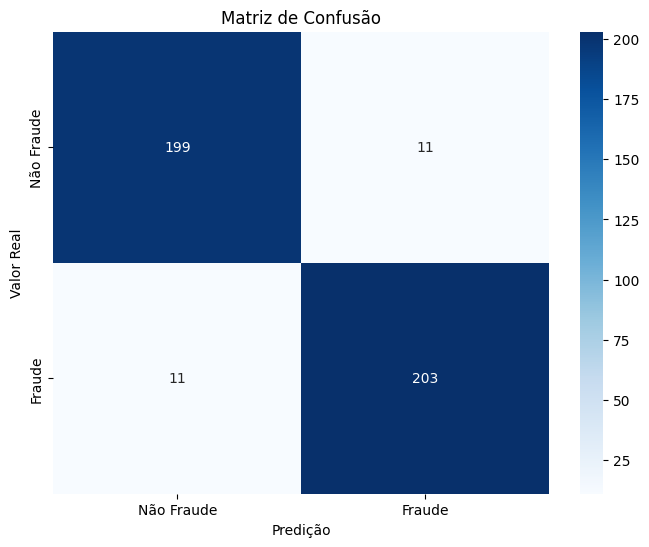

In [106]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Obter as previsões do modelo para o conjunto de teste
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Calcular a matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# Plotar a matriz de confusão usando seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Não Fraude', 'Fraude'],
            yticklabels=['Não Fraude', 'Fraude'])
plt.xlabel('Predição')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusão')
plt.show()

## 3. Treinamento de uma Rede LSTM:


Estruture os dados no formato adequado para a aplicação de uma rede LSTM, levando em consideração a natureza sequencial do consumo de água ao longo dos meses.

Crie uma rede LSTM utilizando Keras, treinando-a para realizar a detecção de fraudes.

Ao final, avalie o modelo utilizando as mesmas métricas da rede feedforward: acurácia, F1-score, precisão e revocação.

In [98]:
X_balanced

,categoria,consumo_m3
1047,1,10.017327
51,0,43.863659
1512,0,57.161298
778,1,8.794371
2336,0,32.239426
...,...,...
4450,1,4.541442
4451,1,4.246494
4452,1,5.124552
4453,1,4.460749


In [99]:
y_balanced

1047    0
51      0
1512    0
778     0
2336    0
       ..
4450    1
4451    1
4452    1
4453    1
4454    1
Name: fraude, Length: 2116, dtype: int64

In [103]:
def create_time_windows_scaled(X_resampled, TransactionDT, time_steps=1):
    if not isinstance(TransactionDT, pd.DatetimeIndex):
        TransactionDT = pd.to_datetime(TransactionDT)

    if not isinstance(TransactionDT, pd.Series):
        TransactionDT = TransactionDT.to_pandas()

    TransactionDT_diff = TransactionDT.diff().dt.days.fillna(0)

    windows = []
    window_start = 0

    for i in range(1, len(X_resampled)):
        if TransactionDT_diff.iloc[i] >= time_steps:
            windows.append(X_resampled[window_start:i])
            window_start = i

    if window_start < len(X_resampled):
        windows.append(X_resampled[window_start:])

    return windows

windows = create_time_windows_scaled(X_balanced, df['data_leitura'], time_steps=30)

In [104]:
def create_sequences_from_windows_scaled(windows, y, time_steps):
    X_seq, y_seq = [], []
    for window in windows:
        y_window = y[:len(window)]  # Assume que y tem o mesmo tamanho de X

        # Criar sequências dentro de cada janela
        for i in range(len(window) - time_steps):
            X_seq.append(window[i:i+time_steps])
            y_seq.append(y_window[i+time_steps])
    return np.array(X_seq), np.array(y_seq)

# Criação das sequências a partir dessas janelas
time_steps = 30  # Por exemplo, 10 transações consecutivas
X_seq, y_seq = create_sequences_from_windows_scaled(windows, y_balanced.values, time_steps)

In [105]:
print(X_seq.shape, y_seq.shape)

(0,) (0,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

In [ ]:
def create_model(X_train, optimizer=Adam, learn_rate=0.001):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(100, return_sequences=True))  # Mantém todas as saídas
    model.add(LSTM(50, return_sequences=True))   # Mantém todas as saídas
    model.add(LSTM(25, return_sequences=False))  # Retorna apenas a última célula de saída
    model.add(Dense(1, activation='sigmoid'))    # Camada de saída para classificação binária

    model.compile(
        optimizer=optimizer(learning_rate=learn_rate),
        loss='binary_crossentropy',
        metrics=[Accuracy(), Precision(), Recall(), AUC()]
    )

    return model

In [ ]:
model = create_model(X_train)
model.summary()

In [ ]:
history = model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=1, validation_data=(X_test, y_test))

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=history.history['loss'], mode='lines', name='loss'))
fig.add_trace(go.Scatter(y=history.history['val_loss'], mode='lines', name='val_loss'))
fig.update_layout(title='Loss vs. Epochs', xaxis_title='Epochs', yaxis_title='Loss')
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=history.history['precision_2'], mode='lines', name='precision'))
fig.add_trace(go.Scatter(y=history.history['val_precision_2'], mode='lines', name='val_precision'))
fig.update_layout(title='Precision vs. Epochs', xaxis_title='Epochs', yaxis_title='Precision')
fig.show()

In [ ]:
loss, accuracy, precision, recall, auc = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, AUC: {roc_auc_score(y_test, model.predict(X_test))}')

In [ ]:
# Calculando métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

# Imprimindo os resultados
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'AUC-ROC: {auc}')

## 4. Análise Comparativa:

Compare o desempenho entre os dois modelos (feedforward e LSTM). Discuta as diferenças nas métricas de desempenho e qual modelo se mostrou mais eficaz na detecção de fraudes.

Justifique possíveis razões para a diferença de desempenho, considerando as características dos modelos e o comportamento dos dados.

In [ ]:
# é possível analisar a matriz de confusão e as métricas presentes dentro dos blocos acima, além de termos os gráficos do modelo#

## 5. Discussão das Consequências para a Empresa:

Discuta as implicações práticas da implementação de cada modelo pela DeságuaPK. Considere o impacto de falsos positivos (clientes honestos acusados de fraude) e falsos negativos (fraudes não detectadas).

Avalie os custos e benefícios de utilizar cada um dos modelos, tanto em termos financeiros quanto operacionais, e qual deles poderia trazer melhores resultados a longo prazo para a empresa.

- Referente ao modelo feedfoward, foi possível perceber que tivemos um resultado bem satisfatório, devido aos tipos de dados que tinhamos.
- Logo será extramamente benéfico para a empresa em utilizar o modelo desenvolvido.
- Não é muito custoso para a empresa em fazer um modelo como esse e é extremamente benéfico para as predições.